In [1]:
import tensorflow as tf


In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-26 06:57:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   201MB/s    in 0.6s    

2022-05-26 06:57:05 (201 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [3]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

# tensorboard_callback

In [4]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir  = dir_name +"/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# image_dataset_from_directory

In [5]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,batch_size=32,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

In [7]:
data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomFlip("horizontal"),
                                         preprocessing.RandomRotation(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

# **Model 1: Feature extraction transfer learning on 1% of the data with data augmentation**

In [8]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape,name="input_layer")
x= data_augmentation(inputs)
x= base_model(x,training=False )
x= layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs =layers.Dense(10,activation='Softmax',name="output_layer")(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220526-065713
Epoch 1/5
3/3 [==============================] - 21s 2s/step - loss: 2.2672 - accuracy: 0.1714 - val_loss: 2.1360 - val_accuracy: 0.2138
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0240 - accuracy: 0.3143 - val_loss: 2.0153 - val_accuracy: 0.3043
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8158 - accuracy: 0.4571 - val_loss: 1.9164 - val_accuracy: 0.3882
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7393 - accuracy: 0.4429 - val_loss: 1.8435 - val_accuracy: 0.4441
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.5385 - accuracy: 0.7143 - val_loss: 1.7458 - val_accuracy: 0.5049


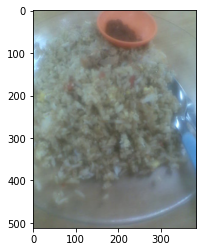

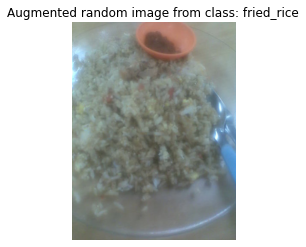

In [9]:
import random
import os
import matplotlib.image as  mpimg
import matplotlib.pyplot as plt
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)

augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [10]:
# Check out model summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [11]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.7655 - accuracy: 0.4688


[1.765480637550354, 0.46880000829696655]

In [12]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

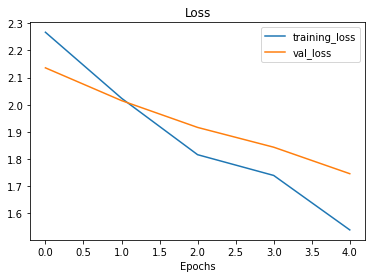

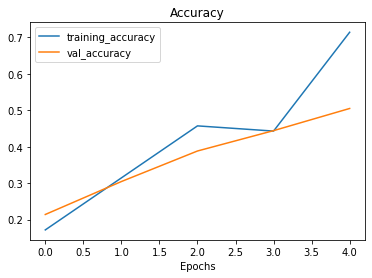

In [13]:
plot_loss_curves(history_1_percent)

In [14]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-26 06:58:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-26 06:58:06 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [15]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [16]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-05-26 06:58:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  47.7MB/s    in 29s     

2022-05-26 06:58:36 (54.3 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [17]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_f

In [18]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [19]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big  model with transfer learning on 10% of 101 food classes


In [20]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=True,monitor='val_accuracy')

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

In [22]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [23]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False
inputs = layers.Input(shape=(224,224,3),name='input_layer')
x = data_augmentation(inputs)
x= base_model(x,training=False)
x= layers.GlobalMaxPooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [25]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 77s 297ms/step - loss: 5.4812 - accuracy: 0.1312 - val_loss: 4.3125 - val_accuracy: 0.2280
Epoch 2/5
237/237 [==============================] - 59s 244ms/step - loss: 3.5221 - accuracy: 0.3163 - val_loss: 4.2771 - val_accuracy: 0.2783
Epoch 3/5
237/237 [==============================] - 53s 222ms/step - loss: 2.9380 - accuracy: 0.3933 - val_loss: 3.6086 - val_accuracy: 0.3578
Epoch 4/5
237/237 [==============================] - 52s 217ms/step - loss: 2.6681 - accuracy: 0.4413 - val_loss: 3.2348 - val_accuracy: 0.3898
Epoch 5/5
237/237 [==============================] - 46s 195ms/step - loss: 2.2934 - accuracy: 0.4859 - val_loss: 3.5873 - val_accuracy: 0.3684


In [26]:
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 57s 72ms/step - loss: 2.9605 - accuracy: 0.4416


[2.9605135917663574, 0.44158416986465454]

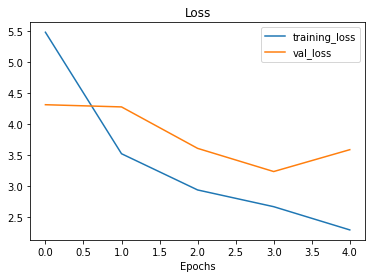

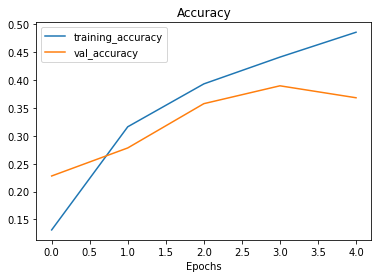

In [27]:
plot_loss_curves(history_all_classes_10_percent)

# Fine Tuning

In [28]:
base_model.trainable= True
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [29]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [30]:
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 45s 189ms/step - loss: 2.1323 - accuracy: 0.5145 - val_loss: 3.6886 - val_accuracy: 0.3758
Epoch 6/10
237/237 [==============================] - 43s 178ms/step - loss: 2.0627 - accuracy: 0.5324 - val_loss: 3.0734 - val_accuracy: 0.4415
Epoch 7/10
237/237 [==============================] - 42s 174ms/step - loss: 1.9422 - accuracy: 0.5525 - val_loss: 4.0883 - val_accuracy: 0.3559
Epoch 8/10
237/237 [==============================] - 39s 165ms/step - loss: 1.7927 - accuracy: 0.5780 - val_loss: 3.6544 - val_accuracy: 0.4062
Epoch 9/10
237/237 [==============================] - 40s 166ms/step - loss: 1.7325 - accuracy: 0.5904 - val_loss: 3.6262 - val_accuracy: 0.4108
Epoch 10/10
237/237 [==============================] - 37s 155ms/step - loss: 1.6235 - accuracy: 0.6135 - val_loss: 3.5425 - val_accuracy: 0.4158


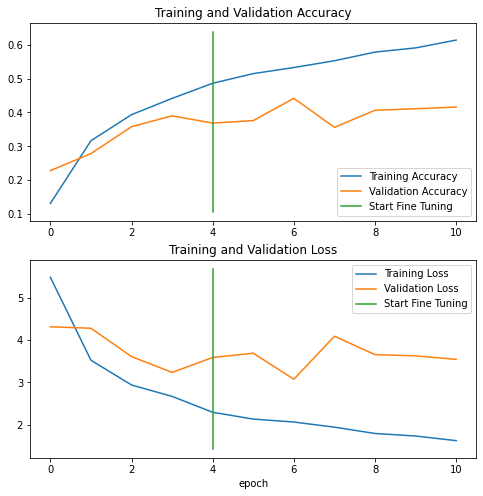

In [31]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [32]:
model.save("drive/My Drive/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/101_food_class_10_percent_saved_big_dog_model/assets


In [33]:
model = tf.keras.models.load_model("drive/My Drive/101_food_class_10_percent_saved_big_dog_model")

In [34]:
model.evaluate(test_data)

790/790 [==============================] - 60s 72ms/step - loss: 3.0222 - accuracy: 0.4796


[3.0221974849700928, 0.4796435534954071]

In [35]:
pred_probs = model.predict(test_data)

In [36]:
pred_probs.shape

(25250, 101)

In [37]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([49,  0, 30, 38, 29, 80, 29,  0,  2,  0])

In [39]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Evaluating predictions

In [40]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.4796435643564356

In [41]:
# Get the class names
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.28      0.16      0.20       250
           1       0.38      0.65      0.48       250
           2       0.60      0.54      0.57       250
           3       0.72      0.37      0.49       250
           4       0.63      0.22      0.33       250
           5       0.59      0.10      0.18       250
           6       0.65      0.72      0.68       250
           7       0.75      0.66      0.70       250
           8       0.47      0.12      0.19       250
           9       0.77      0.20      0.32       250
          10       0.40      0.46      0.43       250
          11       0.45      0.58      0.51       250
          12       0.38      0.71      0.49       250
          13       0.61      0.27      0.38       250
          14       0.48      0.52      0.50       250
          15       0.32      0.14      0.19       250
          16       0.55      0.30      0.39       250
          17       0.40    